In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(26),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 5057


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001, weight_decay=0.0001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1392.91it/s]


Epoch   1/100: RMSE_train: 1,659,004, RMSE_val: 1,402,364


100%|██████████| 646/646 [00:00<00:00, 1478.37it/s]


Epoch   2/100: RMSE_train: 1,134,777, RMSE_val: 1,251,989


100%|██████████| 646/646 [00:00<00:00, 1493.20it/s]


Epoch   3/100: RMSE_train: 1,029,281, RMSE_val: 1,200,256


100%|██████████| 646/646 [00:00<00:00, 1506.98it/s]


Epoch   4/100: RMSE_train: 1,011,422, RMSE_val: 1,144,178


100%|██████████| 646/646 [00:00<00:00, 1449.81it/s]


Epoch   5/100: RMSE_train: 987,309, RMSE_val: 1,108,048


100%|██████████| 646/646 [00:00<00:00, 1481.29it/s]


Epoch   6/100: RMSE_train: 966,315, RMSE_val: 1,083,548


100%|██████████| 646/646 [00:00<00:00, 1415.83it/s]


Epoch   7/100: RMSE_train: 967,891, RMSE_val: 1,050,526


100%|██████████| 646/646 [00:00<00:00, 1341.06it/s]


Epoch   8/100: RMSE_train: 964,264, RMSE_val: 1,023,114


100%|██████████| 646/646 [00:00<00:00, 1488.98it/s]


Epoch   9/100: RMSE_train: 961,000, RMSE_val: 1,000,041


100%|██████████| 646/646 [00:00<00:00, 1491.50it/s]


Epoch  10/100: RMSE_train: 955,141, RMSE_val: 982,227


100%|██████████| 646/646 [00:00<00:00, 1488.43it/s]


Epoch  11/100: RMSE_train: 944,577, RMSE_val: 966,004


100%|██████████| 646/646 [00:00<00:00, 1493.18it/s]


Epoch  12/100: RMSE_train: 953,386, RMSE_val: 955,599


100%|██████████| 646/646 [00:00<00:00, 1496.66it/s]


Epoch  13/100: RMSE_train: 929,985, RMSE_val: 948,710


100%|██████████| 646/646 [00:00<00:00, 1393.79it/s]


Epoch  14/100: RMSE_train: 937,720, RMSE_val: 933,994


100%|██████████| 646/646 [00:00<00:00, 1488.84it/s]


Epoch  15/100: RMSE_train: 931,773, RMSE_val: 927,773


100%|██████████| 646/646 [00:00<00:00, 1499.52it/s]


Epoch  16/100: RMSE_train: 934,044, RMSE_val: 924,594


100%|██████████| 646/646 [00:00<00:00, 1497.61it/s]


Epoch  17/100: RMSE_train: 928,463, RMSE_val: 923,598


100%|██████████| 646/646 [00:00<00:00, 1479.26it/s]


Epoch  18/100: RMSE_train: 928,433, RMSE_val: 920,819


100%|██████████| 646/646 [00:00<00:00, 1456.95it/s]


Epoch  19/100: RMSE_train: 925,621, RMSE_val: 915,056


100%|██████████| 646/646 [00:00<00:00, 1420.82it/s]


Epoch  20/100: RMSE_train: 922,463, RMSE_val: 921,810
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1480.98it/s]


Epoch  21/100: RMSE_train: 923,271, RMSE_val: 948,072
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1491.98it/s]


Epoch  22/100: RMSE_train: 923,163, RMSE_val: 915,810
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1440.58it/s]


Epoch  23/100: RMSE_train: 917,888, RMSE_val: 913,115


100%|██████████| 646/646 [00:00<00:00, 1474.21it/s]


Epoch  24/100: RMSE_train: 917,945, RMSE_val: 917,913
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1455.70it/s]


Epoch  25/100: RMSE_train: 920,715, RMSE_val: 913,068


100%|██████████| 646/646 [00:00<00:00, 1465.52it/s]


Epoch  26/100: RMSE_train: 925,746, RMSE_val: 911,423


100%|██████████| 646/646 [00:00<00:00, 1361.22it/s]


Epoch  27/100: RMSE_train: 915,911, RMSE_val: 919,466
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1493.43it/s]


Epoch  28/100: RMSE_train: 910,699, RMSE_val: 913,194
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1439.67it/s]


Epoch  29/100: RMSE_train: 915,634, RMSE_val: 914,565
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1460.31it/s]


Epoch  30/100: RMSE_train: 928,820, RMSE_val: 930,843
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 1457.98it/s]


Epoch  31/100: RMSE_train: 910,724, RMSE_val: 915,207
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1453.73it/s]


Epoch  32/100: RMSE_train: 905,857, RMSE_val: 918,580
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 1267.97it/s]


Epoch  33/100: RMSE_train: 919,359, RMSE_val: 920,851
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 1481.56it/s]


Epoch  34/100: RMSE_train: 910,227, RMSE_val: 914,656
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1447.69it/s]


Epoch  35/100: RMSE_train: 922,461, RMSE_val: 919,622
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1314.52it/s]


Epoch  36/100: RMSE_train: 908,068, RMSE_val: 916,322
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1435.34it/s]


Epoch  37/100: RMSE_train: 896,375, RMSE_val: 919,205
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1405.29it/s]


Epoch  38/100: RMSE_train: 904,653, RMSE_val: 918,293
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 963.79it/s] 


Epoch  39/100: RMSE_train: 906,360, RMSE_val: 927,587
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 1357.10it/s]


Epoch  40/100: RMSE_train: 901,045, RMSE_val: 922,906
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1493.56it/s]


Epoch  41/100: RMSE_train: 908,744, RMSE_val: 923,687
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 1474.32it/s]


Epoch  42/100: RMSE_train: 912,347, RMSE_val: 919,886
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 1484.14it/s]


Epoch  43/100: RMSE_train: 911,639, RMSE_val: 922,215
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 1524.99it/s]


Epoch  44/100: RMSE_train: 906,977, RMSE_val: 922,214
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 1508.39it/s]


Epoch  45/100: RMSE_train: 903,828, RMSE_val: 936,500
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 1516.93it/s]


Epoch  46/100: RMSE_train: 887,973, RMSE_val: 927,072
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1448.43it/s]


Epoch  47/100: RMSE_train: 900,712, RMSE_val: 933,816
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 1487.11it/s]


Epoch  48/100: RMSE_train: 895,121, RMSE_val: 926,660
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 1480.93it/s]


Epoch  49/100: RMSE_train: 905,661, RMSE_val: 927,969
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 1440.72it/s]


Epoch  50/100: RMSE_train: 907,577, RMSE_val: 929,087
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 1468.21it/s]


Epoch  51/100: RMSE_train: 914,174, RMSE_val: 933,161
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 1383.24it/s]


Epoch  52/100: RMSE_train: 904,956, RMSE_val: 928,482
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1407.37it/s]


Epoch  53/100: RMSE_train: 897,660, RMSE_val: 927,303
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 1499.34it/s]


Epoch  54/100: RMSE_train: 911,515, RMSE_val: 929,344
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1467.88it/s]


Epoch  55/100: RMSE_train: 899,886, RMSE_val: 934,931
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 1514.24it/s]


Epoch  56/100: RMSE_train: 898,038, RMSE_val: 932,771
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 1533.92it/s]


Epoch  57/100: RMSE_train: 895,141, RMSE_val: 932,475
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 1535.39it/s]


Epoch  58/100: RMSE_train: 893,287, RMSE_val: 937,614
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1525.93it/s]


Epoch  59/100: RMSE_train: 899,546, RMSE_val: 936,250
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1515.29it/s]


Epoch  60/100: RMSE_train: 898,048, RMSE_val: 932,103
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1522.60it/s]


Epoch  61/100: RMSE_train: 900,628, RMSE_val: 934,275
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1509.37it/s]


Epoch  62/100: RMSE_train: 896,087, RMSE_val: 940,636
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1463.26it/s]


Epoch  63/100: RMSE_train: 885,837, RMSE_val: 930,721
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1436.43it/s]


Epoch  64/100: RMSE_train: 904,003, RMSE_val: 933,367
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 1491.29it/s]


Epoch  65/100: RMSE_train: 907,023, RMSE_val: 937,611
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 1526.51it/s]


Epoch  66/100: RMSE_train: 895,746, RMSE_val: 939,830
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 1525.55it/s]


Epoch  67/100: RMSE_train: 893,060, RMSE_val: 932,519
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 1530.57it/s]


Epoch  68/100: RMSE_train: 891,306, RMSE_val: 941,242
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 1449.38it/s]


Epoch  69/100: RMSE_train: 899,396, RMSE_val: 937,016
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 1518.46it/s]


Epoch  70/100: RMSE_train: 887,391, RMSE_val: 936,470
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 1505.14it/s]


Epoch  71/100: RMSE_train: 889,869, RMSE_val: 938,744
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 1473.57it/s]


Epoch  72/100: RMSE_train: 887,152, RMSE_val: 937,166
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 1498.93it/s]


Epoch  73/100: RMSE_train: 890,962, RMSE_val: 938,139
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 1446.89it/s]


Epoch  74/100: RMSE_train: 894,325, RMSE_val: 936,593
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 1514.77it/s]


Epoch  75/100: RMSE_train: 897,614, RMSE_val: 937,763
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 1491.68it/s]


Epoch  76/100: RMSE_train: 888,084, RMSE_val: 932,192
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 1490.25it/s]


Epoch  77/100: RMSE_train: 892,338, RMSE_val: 937,460
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 1480.38it/s]


Epoch  78/100: RMSE_train: 898,419, RMSE_val: 946,361
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 1459.55it/s]


Epoch  79/100: RMSE_train: 883,463, RMSE_val: 933,837
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 1523.12it/s]


Epoch  80/100: RMSE_train: 887,790, RMSE_val: 935,736
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 1519.80it/s]


Epoch  81/100: RMSE_train: 889,723, RMSE_val: 934,265
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 1513.98it/s]


Epoch  82/100: RMSE_train: 900,072, RMSE_val: 937,156
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 1518.14it/s]


Epoch  83/100: RMSE_train: 884,381, RMSE_val: 946,673
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 1538.92it/s]


Epoch  84/100: RMSE_train: 884,672, RMSE_val: 943,593
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 1525.64it/s]


Epoch  85/100: RMSE_train: 889,249, RMSE_val: 938,273
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 1476.04it/s]


Epoch  86/100: RMSE_train: 891,718, RMSE_val: 945,473
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 1524.95it/s]


Epoch  87/100: RMSE_train: 899,686, RMSE_val: 936,624
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 1526.77it/s]


Epoch  88/100: RMSE_train: 877,228, RMSE_val: 935,095
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 1528.98it/s]


Epoch  89/100: RMSE_train: 888,969, RMSE_val: 936,064
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 1524.48it/s]


Epoch  90/100: RMSE_train: 884,508, RMSE_val: 933,979
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 1532.04it/s]


Epoch  91/100: RMSE_train: 893,827, RMSE_val: 1,022,476
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 1527.85it/s]


Epoch  92/100: RMSE_train: 886,263, RMSE_val: 943,011
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 1526.47it/s]


Epoch  93/100: RMSE_train: 888,540, RMSE_val: 940,901
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 1538.77it/s]


Epoch  94/100: RMSE_train: 890,018, RMSE_val: 938,756
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 1523.07it/s]


Epoch  95/100: RMSE_train: 885,833, RMSE_val: 946,094
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 1524.89it/s]


Epoch  96/100: RMSE_train: 889,157, RMSE_val: 940,896
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 1531.48it/s]


Epoch  97/100: RMSE_train: 882,627, RMSE_val: 936,940
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 1527.11it/s]


Epoch  98/100: RMSE_train: 878,938, RMSE_val: 941,799
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 1525.17it/s]


Epoch  99/100: RMSE_train: 875,948, RMSE_val: 941,559
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 1522.18it/s]

Epoch 100/100: RMSE_train: 875,258, RMSE_val: 940,759
EarlyStopping counter: 74 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   782436.649  439396.432  0.556  0.607
val     913689.328  502083.905  0.627  0.455
test    934612.737  506013.158  0.606  0.436
--------------------------------------------
total   828688.628  458987.662  0.573  0.558


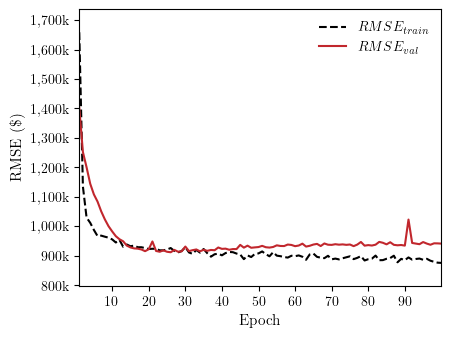

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

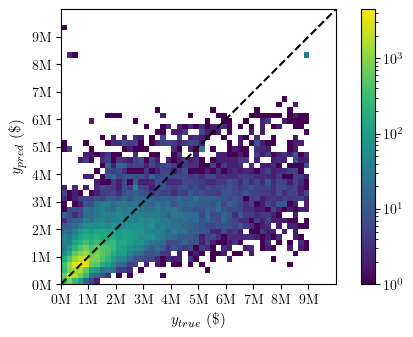

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')